# Results plotting notebook

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np
from matplotlib.patches import Rectangle
from matplotlib.container import BarContainer
from scipy.stats import fisher_exact

sys.path.append(str(Path().absolute().parent))

COLORS_IDENTIFICATION = [c for c in sns.color_palette("PuBu", 3, desat=0.6)]

In [2]:
def plot_identification(
    res,
    true_shift,
    ax=None,
    add_y_axis=False,
    title=None,
):
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(15, 5))

    sns.set_palette("colorblind", color_codes=True)

    cross_dfs = [
        pd.crosstab(res["n_test"], res["final_identified_shift"], normalize="index"),
    ]

    n_tests = np.sort(res.n_test.unique())
    n_tests_map = {x: i for i, x in enumerate(n_tests, 1)}

    w = 0.65

    all_shifts = ["Prevalence shift", "Covariate only", "Covariate + Prevalence"]
    hatch = [".." if true_shift != x else None for x in all_shifts]
    for m, (cross_df, color) in enumerate(zip(cross_dfs, COLORS_IDENTIFICATION)):
        for s in all_shifts:
            if s not in cross_df.columns:
                cross_df[s] = 0
        ax.bar(
            x=[n_tests_map[x] for x in cross_df.index.values],
            height=cross_df[all_shifts[2]],
            bottom=cross_df[all_shifts[:2]].apply(lambda x: x.sum(), axis=1),
            width=w,
            hatch=hatch[-1],
            fill=True,
            edgecolor="Black",
            label="Covariate + Prevalence",
            color=COLORS_IDENTIFICATION[-1],
            linewidth=0.5,
        )
        ax.bar(
            x=[n_tests_map[x] for x in cross_df.index.values],
            height=cross_df[all_shifts[1]],
            bottom=cross_df[all_shifts[:1]].apply(lambda x: x.sum(), axis=1),
            width=w,
            hatch=hatch[-2],
            fill=True,
            edgecolor="Black",
            label="Covariate only",
            color=COLORS_IDENTIFICATION[-2],
            linewidth=0.5,
        )

        ax.bar(
            x=[n_tests_map[x] for x in cross_df.index.values],
            height=cross_df[all_shifts[0]],
            width=w,
            fill=True,
            label="Prevalence shift",
            color=COLORS_IDENTIFICATION[-3],
            hatch=hatch[-3],
            edgecolor="Black",
            linewidth=0.5,
        )
        ax.set_ylabel("Identified shift (%)")
    ax.set_xticks(np.arange(1, n_tests.shape[0] + 1, 1))
    ax.set_xticklabels(n_tests.astype(int))

    ax.set_ylim((-0.1, 1.1))
    ax.set_yticks(np.arange(0, 101, 25).astype(float) / 100)
    ax.set_yticklabels(np.arange(0, 101, 25))
    if title is not None:
        ax.set_title(title)
    if not add_y_axis:
        ax.set_ylabel("")
    ax.grid(axis="y")
    sns.despine()
    plt.tight_layout()


def add_identification_legend(ax, position="center"):
    ax.axis("off")
    names = ["Prevalence shift", "Covariate only", "Covariate + Prevalence"]

    # Define legend entries and colors
    handles = []
    for label, color in zip(names, COLORS_IDENTIFICATION):
        handle = Rectangle(
            (0, 0), 1, 1, facecolor=color, label=label, edgecolor="black"
        )
        handles.append(handle)

    ax.add_artist(
        ax.legend(
            handles,
            names,
            loc=position,
            ncol=len(names),
        )
    )

    labels2 = ["Correct", "Incorrect"]

    handles2 = [
        Rectangle((0, 0), 0.1, 0.1, label=label, fill=True, color="black"),
        Rectangle((0, 0), 1, 1, hatch="..", label=label, fill=False, edgecolor="black"),
    ]

    ax.add_artist(
        ax.legend(
            handles + handles2,
            names + labels2,
            loc=position,
            ncol=len(names) + 2,
        )
    )


sns.set_theme(style="white")


def plot_all(
    encoder_res_list,
    encoder_names,
    duo_res,
    ax=None,
    col="mmd_is_significant",
    add_y_axis=False,
    title=None,
    colors=None,
    plot_significance=True,
):
    if isinstance(col, str):
        col = [col] * len(encoder_res_list)
    res_to_plot = []
    if duo_res is not None:
        all_res_list = [duo_res] + encoder_res_list + [duo_res]
        encoder_names = ["BBSD"] + encoder_names + ["Duo"]
        all_cols = ["bbsd_is_significant"] + col + ["duo_is_significant"]
    else:
        all_res_list = encoder_res_list
        all_cols = encoder_names
        all_cols = col

    for res, c in zip(all_res_list, all_cols):
        res["res"] = res[c].apply(lambda x: "Shift detected" if x else "No shift")
        res_to_plot.append(res[["n_test", "res"]])

    all_cross = [
        pd.crosstab(res["n_test"], res["res"], normalize="index") for res in res_to_plot
    ]

    test_sizes = encoder_res_list[0].n_test.unique()
    n_tests = np.sort(test_sizes)
    n_tests_map = {x: i for i, x in enumerate(n_tests, 1)}

    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(15, 5))

    w = 0.8
    width = w / len(all_cross)
    if colors is None:
        colors = [DETECTION_COLOR_DICT[x] for x in encoder_names]

    n_bars = len(encoder_names)

    for m, (cross_df, color) in enumerate(zip(all_cross, colors)):
        x = [n_tests_map[x] - (n_bars / 2.0 - m) * width for x in cross_df.index.values]
        heights = cross_df["Shift detected"]
        ax.bar(
            x=x,
            height=heights,
            width=width,
            fill=True,
            edgecolor="Black",
            color=color,
            linewidth=0.8,
        )
        ax.set_ylabel("Detected shift (%)")

    if plot_significance:
        all_bars = []
        all_bars_x = []
        for i in ax.containers:
            if isinstance(i, BarContainer):
                all_bars.extend([patch.get_height() for patch in i])
                all_bars_x.extend([patch.get_x() for patch in i])
        df = pd.DataFrame(data={"y": all_bars, "x": all_bars_x})
        heights = df.groupby(by="x").max().sort_index().values.reshape((-1,))
        max_plotted = 1
        for n in test_sizes:
            all_bars_x_n = [
                n_tests_map[n] - (n_bars / 2.0 - m) * width
                for m in range(len(all_cross))
            ]
            freq = [
                (res.loc[res.n_test == n, "res"] == "Shift detected")
                for res in res_to_plot
            ]
            all_counts = np.stack([np.bincount(f, minlength=2) for f in freq], axis=0)
            print(all_counts.shape[0])
            best_detected = np.argmax(all_counts[:, 1])
            print(best_detected)
            for i in range(all_counts.shape[0]):
                p_value = fisher_exact(
                    np.vstack([all_counts[best_detected], all_counts[i]])
                ).pvalue * len(all_counts - 1)
                if p_value > 0.05:
                    ax.text(
                        all_bars_x_n[i] - width / 4,
                        (all_counts[i, 1] / all_counts[i].sum()) - 0.02,
                        s="*",
                        fontdict={"fontsize": 20},
                    )

        ax.set_ylim((-max_plotted * 0.04, 1.2))

    ax.set_xticks(np.arange(1, n_tests.shape[0] + 1, 1))
    ax.set_xticklabels(n_tests.astype(int))
    ax.set_yticks(np.arange(0, 101, 25).astype(float) / 100)
    ax.set_yticklabels(np.arange(0, 101, 25))

    if title is not None:
        ax.set_title(title)
    if not add_y_axis:
        ax.set_ylabel("")
    ax.grid(axis="y")
    sns.despine()
    plt.tight_layout()


def add_legend_comparison(ax, encoder_names, colors=None, ncol=4, add_bssd=True):
    # Define legend entries and colors
    if add_bssd:
        encoder_names = ["BBSD"] + encoder_names + ["Duo"]
        labels = (
            ["BBSD test (task model outputs)"]
            + [f"MMD ({n} features)" for n in encoder_names]
            + ["Duo BBSD + MMD (SimCLR ImageNet)"]
        )
    else:
        labels = [f"MMD ({n} features)" for n in encoder_names]
    ax.axis("off")

    if colors is None:
        colors = [DETECTION_COLOR_DICT[x] for x in encoder_names]

    handles = []
    for label, color in zip(labels, colors):
        handle = Rectangle(
            (0, 0), 1, 1, facecolor=color, label=label, edgecolor="Black"
        )
        handles.append(handle)

    ax.add_artist(
        ax.legend(
            handles,
            labels,
            loc="center",
            ncol=ncol,
            title=" ".join([r"$\bf{" + x + r"}$" for x in "Shift detector".split(" ")]),
        )
    )


DETECTION_COLOR_DICT = {
    "BBSD": "indianred",
    "Random encoder": "lightcyan",
    "Supervised ImageNet": "lightskyblue",
    "Task model": "steelblue",
    "SimCLR ImageNet": "cornflowerblue",
    "SimCLR Modality Specific": "midnightblue",
    "Retfound": "blue",
    "Duo": "orange",
}

# Part 0: loading results

In [3]:
imagenet_simclr_encoder_id = "simclr_imagenet"
random_encoder_id = "random"
imagenet_supervised_id = "imagenet"

# CXR
cxr_ssl_encoder = (
    "/vol/biomedic3/mb121/causal-contrastive/outputs/run_q0kry6pk/best.ckpt"
)
cxr_ssl_encoder_id = Path(cxr_ssl_encoder).parent.stem[4:]
rsna_model_to_evaluate = (
    "/vol/biomedic3/mb121/shift_identification/outputs/run_j0c09xra/best.ckpt"
)
rsna_model_id = Path(rsna_model_to_evaluate).parent.stem[4:]

padchest_model_to_evaluate = (
    "/vol/biomedic3/mb121/shift_identification/outputs/run_h4tbta6v/best.ckpt"
)
padchest_model_id = Path(padchest_model_to_evaluate).parent.stem[4:]
n_cls_cxr = 2
val_size_cxr = 2000

# EMBED
embed_model_to_evaluate = (
    "/vol/biomedic3/mb121/shift_identification/outputs/run_zexo630s/best.ckpt"
)
embed_model_id = Path(embed_model_to_evaluate).parent.stem[4:]
mammo_ssl_encoder = (
    "/vol/biomedic3/mb121/causal-contrastive/outputs/run_byatk1eo/best.ckpt"
)
mammo_ssl_encoder_id = Path(mammo_ssl_encoder).parent.stem[4:]
n_cls_embed = 4
val_size_embed = 1000  # exams

# RETINA
retina_model_to_evaluate = (
    "/vol/biomedic3/mb121/shift_identification/outputs/run_ve3it5qy/best.ckpt"
)
retina_model_id = Path(retina_model_to_evaluate).parent.stem[4:]
n_cls_retina = 2
val_size_retina = 1000


# General constants
n_boostraps_cxr = 200
n_boostraps = 200
test_sizes = [100, 250, 500, 1000]  # number of images
test_sizes_embed = [50, 100, 250]  # number of exams

# Part I: which dataset shift detectors do we need for which type of shifts?

## A: No shift

Missing outputs/retina_prev_0.78_n200_ve3it5qy_simclr_imagenet_t[100, 250, 500, 1000].csv
Missing outputs/rsna_prev_0.23_n200_j0c09xra_simclr_imagenetn_v2000_t[100, 250, 500, 1000].csv
Missing outputs/padchest_prev_0.036_n200_h4tbta6v_simclr_imagenet_v2000_t[100, 250, 500, 1000].csv
Missing outputs/mammo_noshift_n200_zexo630s_simclr_imagenet_v1000.csv


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/figures/all_no_shift.pdf'

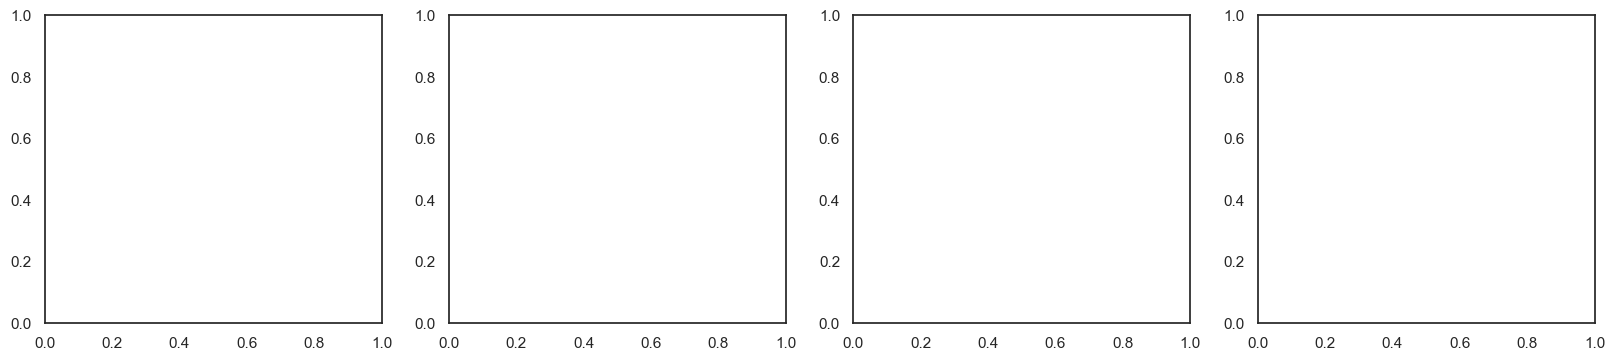

In [4]:
encoder_ids = [
    imagenet_simclr_encoder_id,
]

encoders = [
    "SimCLR ImageNet",
]

csv_to_plot = {
    "RETINA": f"outputs/retina_prev_0.78_n{n_boostraps}_{retina_model_id}_{imagenet_simclr_encoder_id}_t{test_sizes}.csv",
    "RSNA Pneumonia": f"outputs/rsna_prev_0.23_n{n_boostraps_cxr}_{rsna_model_id}_{imagenet_simclr_encoder_id}n_v{val_size_cxr}_t{test_sizes}.csv",
    "PadChest": f"outputs/padchest_prev_0.036_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_t{test_sizes}.csv",
    "EMBED": f"outputs/mammo_noshift_n{n_boostraps}_{embed_model_id}_{imagenet_simclr_encoder_id}_v{val_size_embed}.csv",
}

f, ax = plt.subplots(1, 4, figsize=(20, 4))

# TO DO adapt legend
for i, (name, filename) in enumerate(csv_to_plot.items()):
    if Path(filename).exists():
        res = pd.read_csv(filename)
        if name == "EMBED":
            res = res.loc[res.n_test.isin(test_sizes_embed)]
            ax[i].set_xlabel("Number of test exams (4 images per exam)")
        else:
            res = res.loc[res.n_test.isin(test_sizes)]
            ax[i].set_xlabel("Number of test images")
        plot_all(
            [res],
            duo_res=res,
            encoder_names=encoders,
            ax=ax[i],
            add_y_axis=False,
            plot_significance=False,
        )
        ax[i].set_ylim((0, 1))
        ax[i].set_title(f"{name} - No shift")
        ax[i].set_ylabel("Wrongly detected shift (%)")
    else:
        print(f"Missing {filename}")

f.savefig("outputs/figures/all_no_shift.pdf")
f.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(17, 1))
add_legend_comparison(ax, encoders, ncol=4)
f.savefig("outputs/figures/legend_detection_short.pdf", bbox_inches="tight")
f.show()

## RSNA

In [ ]:
encoder_ids = [
    random_encoder_id,
    imagenet_supervised_id,
    rsna_model_id,
    imagenet_simclr_encoder_id,
    cxr_ssl_encoder_id,
]

encoders = [
    "Random encoder",
    "Supervised ImageNet",
    "Task model",
    "SimCLR ImageNet",
    "SimCLR Modality Specific",
]


orig_dist = 0.23
orig_str = f"Original prevalence : {orig_dist*100:.0f}%"
prevalences = [0.10, 0.5, 0.80]
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
plt.suptitle(r"$\bf{RSNA}$ $\bf{Pneumonia}$ - " + orig_str, y=0.95)
true_shift = "Prevalence shift"
for i, prevalence_shifted in enumerate(prevalences, 0):
    all_res = []
    names = []
    for encoder, encoder_id in zip(encoders, encoder_ids):
        filename = f"outputs/rsna_prev_{prevalence_shifted}_n{n_boostraps_cxr}_{rsna_model_id}_{encoder_id}n_v{val_size_cxr}_t{test_sizes}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            all_res.append(res)
            names.append(encoder)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Shifted prevalence: {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
            plot_significance=True,
        )
        ax[i].set_xlabel("Number of test images")
# add_legend_comparison(ax[0], encoders + ['Retfound'], ncol=1)
f.savefig("outputs/figures/rsna_encoders_prev.pdf", bbox_inches="tight")
f.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(17, 1))
add_legend_comparison(ax, encoders + ["Retfound"], ncol=4)
f.savefig("outputs/figures/legend_detection.pdf", bbox_inches="tight")
f.show()

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(17, 1))
add_legend_comparison(ax, encoders, ncol=4)
f.savefig("outputs/figures/legend_detection_no_retfound.pdf", bbox_inches="tight")
f.show()

In [ ]:
orig_dist = 0.44
orig_str = f"Original proportion of females: {orig_dist*100:.0f}%"
prevalences = [0.25, 0.75, 1.0]  #
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
plt.suptitle(
    r"$\bf{RSNA}$ $\bf{Pneumonia}$  - $\bf{Gender}$ $\bf{shift}$" + "\n " + orig_str,
    y=0.95,
)
true_shift = "Other shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder, encoder_id in zip(encoders, encoder_ids):
        filename = f"outputs/rsna_gender_{prevalence_shifted}_n{n_boostraps}_{rsna_model_id}_{encoder_id}n_v{val_size_cxr}_t{test_sizes}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            all_res.append(res)
            names.append(encoder)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Proportion of females: {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 1,
            title=shifted_str,
            plot_significance=True,
        )
        ax[i].set_xlabel("Number of test images")
f.savefig("outputs/figures/rsna_encoders_gender.pdf", bbox_inches="tight")
f.show()

## PadChest

In [ ]:
orig_dist = 0.036
prevalences = [0.15, 0.20, 0.30]
orig_str = f"Original prevalence: {orig_dist*100:.0f}%"
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
plt.suptitle(r"$\bf{PadChest}$ - " + orig_str, y=0.95)

encoder_ids = [
    random_encoder_id,
    imagenet_supervised_id,
    padchest_model_id,
    imagenet_simclr_encoder_id,
    cxr_ssl_encoder_id,
]
encoders = [
    "Random encoder",
    "Supervised ImageNet",
    "Task model",
    "SimCLR ImageNet",
    "SimCLR Modality Specific",
]

for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder, encoder_id in zip(encoders, encoder_ids):
        print(encoder)
        filename = f"outputs/padchest_prev_{prevalence_shifted}_n{n_boostraps_cxr}_{padchest_model_id}_{encoder_id}_v{val_size_cxr}_t{test_sizes}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            all_res.append(res)
            names.append(encoder)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Prevalence: {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of test images")

# add_legend_comparison(ax[0], encoders, ncol=1)
f.savefig("outputs/figures/pad_encoders_prev.pdf", bbox_inches="tight")

In [ ]:
orig_dist = 0.51

prevalences = [0.25, 0.75, 1.0]  # 0.1,
orig_str = f"Original proportion of females: {orig_dist*100:.0f}%"
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
plt.suptitle(r"$\bf{PadChest}$  - $\bf{Gender}$ $\bf{shift}$" + "\n" + orig_str, y=0.95)
true_shift = "Other shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder, encoder_id in zip(encoders, encoder_ids):
        filename = f"outputs/padchest_gender_{prevalence_shifted}_n{n_boostraps}_{padchest_model_id}_{encoder_id}_v{val_size_cxr}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            all_res.append(res)
            names.append(encoder)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Proportion of females: {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of test images")
# add_legend_comparison(ax[0], encoders, ncol=1)
f.savefig("outputs/figures/pad_encoders_gender.pdf", bbox_inches="tight")

In [ ]:
orig_dist = 0.418

prevalences = [0.25, 0.75, 1.0]  # 0.1,
orig_str = f"Original proportion of Phillips: {orig_dist*100:.0f}%"
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
plt.suptitle(
    r"$\bf{PadChest}$ - $\bf{Acquisition}$ $\bf{shift}$" + "\n" + orig_str, y=0.95
)
true_shift = "Other shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder, encoder_id in zip(encoders, encoder_ids):
        filename = f"outputs/padchest_acq_{prevalence_shifted}_n{n_boostraps}_{padchest_model_id}_{encoder_id}_v{val_size_cxr}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            all_res.append(res)
            names.append(encoder)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Proportion of Phillips: {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of test images")
# ax[0].axis('off')
# add_legend_comparison(ax[0], encoders + ['Retfound'], ncol=1)
f.savefig("outputs/figures/pad_encoders_acq.pdf", bbox_inches="tight")

## EMBED

In [ ]:
orig_dist = np.array([0.07, 0.37, 0.47, 0.07])
true_shift = "Prevalence shift"
orig_str = "Original density class distribution: " + ", ".join(
    [f"{p * 100:.0f}%" for p in orig_dist]
)
prevalences = [[0.0, 0.5, 0.5, 0.0], [0.15, 0.35, 0.35, 0.15], [0.10, 0.20, 0.60, 0.10]]
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
f.suptitle(r"$\bf{EMBED}$ - " + orig_str, y=0.95)

encoders_id = [
    random_encoder_id,
    imagenet_supervised_id,
    embed_model_id,
    imagenet_simclr_encoder_id,
    mammo_ssl_encoder_id,
]
encoders = [
    "Random encoder",
    "Supervised ImageNet",
    "Task model",
    "SimCLR ImageNet",
    "SimCLR Modality Specific",
]
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder_id, name in zip(encoders_id, encoders):
        filename = f"outputs/mammo_prev_{prevalence_shifted}_n{n_boostraps}_{embed_model_id}_{encoder_id}_v{val_size_embed}.csv"

        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes_embed)]
            names.append(name)
            all_res.append(res)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = "Density class distribution: " + ", ".join(
            [f"{p * 100:.0f}%" for p in prevalence_shifted]
        )
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of exams (each with 4 images)")
# add_legend_comparison(ax[0], encoders, ncol=1)
# ax[0].set_axis_off()
f.savefig("outputs/figures/mammo_encoder_prev.pdf", bbox_inches="tight")

In [ ]:
orig_dist = np.asarray([0.79, 0.005, 0.05, 0.04, 0.07, 0.05])

orig_str = "Original scanner distribution: " + ",".join(
    [f"{p * 100:.0f}%" for p in orig_dist]
)

prevalences = [
    [0.55, 0.00, 0.10, 0.10, 0.15, 0.10],
    [0.50, 0.00, 0.00, 0.20, 0.20, 0.10],
    [0.33, 0.02, 0.20, 0.15, 0.20, 0.10],
]
width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
f.suptitle(r"$\bf{EMBED}$ - $\bf{Acquisition}$ $\bf{shift}$" + "\n" + orig_str, y=0.95)

true_shift = "Other shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder_id, name in zip(encoders_id, encoders):
        filename = f"outputs/mammo_acq_{prevalence_shifted}_n{n_boostraps}_{embed_model_id}_{encoder_id}_v{val_size_embed}.csv"

        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes_embed)]
            names.append(name)
            all_res.append(res)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = "Scanner distribution: " + ",".join(
            [f"{p * 100:.0f}%" for p in prevalence_shifted]
        )
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of exams (each with 4 images)")
# ax[0].set_axis_off()
f.savefig("outputs/figures/mammo_encoder_acq.pdf", bbox_inches="tight")
# f, ax = plt.subplots(1,1, figsize=(20,2))
# add_legend_comparison(ax[0], encoders, ncol=1)

## RETINA

In [ ]:
orig_dist = 0.78
prevalences = [0.50, 0.65, 1.0]
orig_str = f"Original disease prevalence: {orig_dist}"

width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
f.suptitle(r"$\bf{RETINA}$ - " + orig_str, y=0.95)
encoders_id = [
    random_encoder_id,
    imagenet_supervised_id,
    retina_model_id,
    imagenet_simclr_encoder_id,
    "cwyi1g3d",
    "retfound",
]
encoders = [
    "Random encoder",
    "Supervised ImageNet",
    "Task model",
    "SimCLR ImageNet",
    "SimCLR Modality Specific",
    "Retfound",
]


true_shift = "Prevalence shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder_id, name in zip(encoders_id, encoders):
        filename = f"outputs/retina_prev_{prevalence_shifted}_n{n_boostraps}_{retina_model_id}_{encoder_id}_t{test_sizes}.csv"
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            names.append(name)
            all_res.append(res)
            if encoder_id == imagenet_simclr_encoder_id:
                duo_res = res
        else:
            print("Not found" + filename)

    if len(all_res) > 0:
        shifted_str = f"Prevalence shift {prevalence_shifted * 100:.0f}% ({(prevalence_shifted - orig_dist) * 100:+.0f}%)"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
        )
        ax[i].set_xlabel("Number of test images")
# ax[0].set_axis_off()
# add_legend_comparison(ax[0], encoders, ncol=1)
f.savefig("outputs/figures/retina_encoder_prev.pdf", bbox_inches="tight")

In [ ]:
orig_dist = [0.04, 0.09, 0.87]

prevalences = [[0.20, 0.20, 0.6], [0.05, 0.30, 0.65], [0.30, 0.30, 0.40]]

orig_str = f"Original domain distribution: {orig_dist}"


width = [1.1] + [1 for _ in range(len(prevalences))]
f, ax = plt.subplots(1, len(prevalences), figsize=(15, 3))
f.suptitle(
    r"$\bf{RETINA}$  - $\bf{Acquisition}$ $\bf{shift}$" + "\n " + orig_str, y=0.95
)
true_shift = "Other shift"
for i, prevalence_shifted in enumerate(prevalences):
    all_res = []
    names = []
    for encoder_id, name in zip(encoders_id, encoders):
        filename = f"outputs/retina_acq_{prevalence_shifted}_n{n_boostraps}_{retina_model_id}_{encoder_id}_t{test_sizes}.csv"

        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            names.append(name)
            all_res.append(res)
        else:
            print(filename)

    if len(all_res) > 0:
        shifted_str = f"Domain distribution {prevalence_shifted}"
        plot_all(
            all_res,
            encoder_names=names,
            duo_res=duo_res,
            ax=ax[i],
            add_y_axis=i == 0,
            title=shifted_str,
            plot_significance=True,
        )
        ax[i].set_xlabel("Number of test images")

# add_legend_comparison(ax[0], encoders, ncol=1)
f.savefig("outputs/figures/retina_encoder_acq.pdf", bbox_inches="tight")

# Part 2: from shift detection to shift identification

## Case A: prevalence shift

In [ ]:
prevalences_embed = [
    [0.0, 0.5, 0.5, 0.0],
    [0.15, 0.35, 0.35, 0.15],
    [0.10, 0.20, 0.60, 0.10],
]
orig_dist_embed_density = np.array([0.07, 0.37, 0.47, 0.07])
prevalence_shifts_to_plot = {
    "RETINA": [
        0.78,
        [
            f"outputs/retina_prev_{p}_n{n_boostraps_cxr}_{retina_model_id}_{imagenet_simclr_encoder_id}_t{test_sizes}.csv"
            for p in [0.50, 0.65, 1.0]
        ],
        [0.50, 0.65, 1.0],
    ],
    "RSNA Pneumonia": [
        0.23,
        [
            f"outputs/rsna_prev_{p}_n{n_boostraps}_{rsna_model_id}_{imagenet_simclr_encoder_id}n_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.10, 0.5, 0.80]
        ],
        [0.10, 0.5, 0.80],
    ],
    "PadChest": [
        0.036,
        [
            f"outputs/padchest_prev_{p}_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.15, 0.20, 0.30]
        ],
        [0.15, 0.20, 0.30],
    ],
    "EMBED": [
        orig_dist_embed_density,
        [
            f"outputs/mammo_prev_{p}_n{n_boostraps_cxr}_{embed_model_id}_{imagenet_simclr_encoder_id}_v{val_size_embed}.csv"
            for p in prevalences_embed
        ],
        prevalences_embed,
    ],
}

for name, (orig_dist, filenames, prevalences) in prevalence_shifts_to_plot.items():
    if isinstance(orig_dist, float):
        orig_str = f"Original prevalence: {orig_dist*100:.0f}%"
    else:
        orig_str = "Original class distribution: " + ",".join(
            [f"{p * 100:.0f}%" for p in orig_dist]
        )

    f, ax = plt.subplots(1, len(filenames), figsize=(7, 4), facecolor="none")
    plt.suptitle(r"$\bf{" + f"{name}" + r"}$ - " + orig_str, y=0.95)
    for (
        i,
        (filename, prevalence),
    ) in enumerate(zip(filenames, prevalences)):
        if Path(filename).exists():
            res = pd.read_csv(filename)
            if name == "EMBED":
                res = res.loc[res.n_test.isin(test_sizes_embed)]
                ax[i].set_xlabel("Number of exams (4 images/exam)")
            else:
                res = res.loc[res.n_test.isin(test_sizes)]
                ax[i].set_xlabel("Number of test images")
            if isinstance(prevalence, float):
                shifted_str = f"Prevalence:\n{prevalence * 100:.0f}% ({(prevalence - orig_dist) * 100:+.0f}%)"
            else:
                shifted_str = "Prevalence:\n" + ",".join(
                    [f"{p * 100:.0f}%" for p in prevalence]
                )
            plot_identification(
                res,
                true_shift="Prevalence shift",
                ax=ax[i],
                add_y_axis=i == 0,
                title=shifted_str,
            )
            if i != 1:
                ax[i].set_xlabel("")
        else:
            print(f"Missing {filename}")

    f.savefig(f"outputs/figures/{name}_id_prev.pdf", bbox_inches="tight", dpi=600)
    f.show()

f, ax = plt.subplots(1, 1, figsize=(12, 0.4))
add_identification_legend(ax)
f.savefig("outputs/figures/legend_id.pdf", bbox_inches="tight");

## Case B: Acquisition shift

In [ ]:
embed_domain_distributions = [
    [0.55, 0.00, 0.10, 0.10, 0.15, 0.10],
    [0.50, 0.00, 0.00, 0.20, 0.20, 0.10],
    [0.33, 0.02, 0.20, 0.15, 0.20, 0.10],
]
embed_orig_domain_dist = np.asarray([0.79, 0.005, 0.05, 0.04, 0.07, 0.05])

orig_site_dist_retina = [0.04, 0.09, 0.87]

retina_site_distributions = [
    [0.20, 0.20, 0.6],
    [0.05, 0.30, 0.65],
    [0.30, 0.30, 0.40],
]

prevalence_shifts_to_plot = {
    "RETINA": [
        orig_site_dist_retina,
        [
            f"outputs/retina_acq_{p}_n{n_boostraps}_{retina_model_id}_{imagenet_simclr_encoder_id}_t{test_sizes}.csv"
            for p in retina_site_distributions
        ],
        retina_site_distributions,
    ],
    "PadChest": [
        0.418,
        [
            f"outputs/padchest_acq_{p}_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.25, 0.75, 1.0]
        ],
        [0.25, 0.75, 1.0],
    ],
    "EMBED": [
        embed_orig_domain_dist,
        [
            f"outputs/mammo_acq_{p}_n{n_boostraps}_{embed_model_id}_{imagenet_simclr_encoder_id}_v{val_size_embed}.csv"
            for p in embed_domain_distributions
        ],
        embed_domain_distributions,
    ],
}

for name, (orig_dist, filenames, prevalences) in prevalence_shifts_to_plot.items():
    width = [0.60] + [1 for _ in range(len(filenames))]
    match name:
        case "PadChest":
            orig_str = f"Original proportion of Phillips scans: {orig_dist*100:.0f}%"
        case "EMBED":
            orig_str = "Original scanner distribution: " + ",".join(
                [f"{p * 100:.0f}%" for p in orig_dist]
            )
        case "RETINA":
            orig_str = "Original site distribution: " + ",".join(
                [f"{p * 100:.0f}%" for p in orig_dist]
            )
        case _:
            raise NotImplementedError
    f, ax = plt.subplots(1, len(filenames), figsize=(7, 4), facecolor="none")
    plt.suptitle(
        r"$\bf{"
        + f"{name}"
        + r"}$"
        + r" - $\bf{Acquisition}$ $\bf{shift}$"
        + "\n"
        + orig_str,
        y=0.95,
    )
    for (
        i,
        (filename, prevalence),
    ) in enumerate(zip(filenames, prevalences)):
        if Path(filename).exists():
            res = pd.read_csv(filename)
            if name == "EMBED":
                res = res.loc[res.n_test.isin(test_sizes_embed)]
                ax[i].set_xlabel("Number of test exams (4 images per exam)")
            else:
                res = res.loc[res.n_test.isin(test_sizes)]
                ax[i].set_xlabel("Number of test images")
            if i != 1:
                ax[i].set_xlabel("")
            match name:
                case "PadChest":
                    shifted_str = f"Proportion of Phillips scans:\n{prevalence * 100:.0f}% ({(prevalence - orig_dist) * 100:+.0f}%)"
                case "EMBED":
                    shifted_str = "Scanner distribution:\n" + ",".join(
                        [f"{p * 100:.0f}%" for p in prevalence]
                    )
                case "RETINA":
                    shifted_str = "Site distribution:\n" + ",".join(
                        [f"{p * 100:.0f}%" for p in prevalence]
                    )
                case _:
                    raise NotImplementedError
            plot_identification(
                res,
                true_shift="Covariate only",
                ax=ax[i],
                add_y_axis=i == 0,
                title=shifted_str,
            )
        else:
            print(f"Missing {filename}")

    f.savefig(f"outputs/figures/{name}_id_acq.pdf", bbox_inches="tight")
    f.show()

## Case C: gender shift

In [ ]:
prevalence_shifts_to_plot = {
    "RSNA Pneumonia": [
        0.44,
        [
            f"outputs/rsna_gender_{p}_n{n_boostraps_cxr}_{rsna_model_id}_{imagenet_simclr_encoder_id}n_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.25, 0.75, 1.0]
        ],
        [0.25, 0.75, 1.0],
    ],
    "PadChest": [
        0.51,
        [
            f"outputs/padchest_gender_{p}_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.25, 0.75, 1.0]
        ],
        [0.25, 0.75, 1.0],
    ],
}

for name, (orig_dist, filenames, prevalences) in prevalence_shifts_to_plot.items():
    orig_str = f"Original proportion of females: {orig_dist*100:.0f}%"
    f, ax = plt.subplots(1, len(filenames), figsize=(7, 4), facecolor="none")
    plt.suptitle(
        r"$\bf{"
        + f"{name}"
        + r"}$"
        + r" - $\bf{Gender}$ $\bf{shift}$"
        + "\n"
        + orig_str,
        y=0.95,
    )
    for (
        i,
        (filename, prevalence),
    ) in enumerate(zip(filenames, prevalences)):
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            ax[i].set_xlabel("Number of test images")
            shifted_str = f"Females: {prevalence * 100:.0f}% ({(prevalence - orig_dist) * 100:+.0f}%)"
            plot_identification(
                res,
                true_shift="Covariate only",
                ax=ax[i],
                add_y_axis=i == 0,
                title=shifted_str,
            )
            if i != 1:
                ax[i].set_xlabel("")
        else:
            print(f"Missing {filename}")

    f.savefig(f"outputs/figures/{name}_id_gender.pdf", bbox_inches="tight")
    f.show()

## Case D: gender + prevalence shifts

In [ ]:
prevalence_shifts_to_plot = {
    "RSNA Pneumonia": [
        (0.23, 0.44),
        [
            f"outputs/rsna_gender_prev_{p}_n{n_boostraps_cxr}_{rsna_model_id}_{imagenet_simclr_encoder_id}n_prev{disease_prev}_v{val_size_cxr}_t{test_sizes}.csv"
            for (p, disease_prev) in [(0.75, 0.1), (0.75, 0.5), (1.0, 0.1)]
        ],
        [(0.75, 0.1), (0.75, 0.5), (1.0, 0.1)],
    ],
    "PadChest": [
        (0.036, 0.51),
        [
            f"outputs/padchest_gender_prev_{p}_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_t{test_sizes}.csv"
            for p in [0.25, 0.75, 1.0]
        ],
        [(0.25, 0.15), (0.75, 0.15), (1.0, 0.15)],
    ],
}

for name, (orig_dist, filenames, prevalences) in prevalence_shifts_to_plot.items():
    orig_str = f"Original proportion of females: {orig_dist[1]*100:.0f}%\n Original disease prevalence: {orig_dist[0]*100:.0f}%"
    f, ax = plt.subplots(1, len(filenames), figsize=(7, 4), facecolor="none")
    plt.suptitle(
        r"$\bf{"
        + f"{name}"
        + r"}$"
        + r" - $\bf{Gender}$ $\bf{+}$ $\bf{Prevalence}$ $\bf{shift}$"
        + "\n"
        + orig_str,
        y=0.95,
    )
    for (
        i,
        (filename, (prevalence, disease_prev)),
    ) in enumerate(zip(filenames, prevalences)):
        if Path(filename).exists():
            res = pd.read_csv(filename)
            res = res.loc[res.n_test.isin(test_sizes)]
            ax[i].set_xlabel("Number of test images")
            shifted_str = f"Females: {prevalence * 100:.0f}% ({(prevalence - orig_dist[1]) * 100:+.0f}%)\nDisease prev.: {disease_prev*100:.0f}% ({(disease_prev - orig_dist[0]) * 100:+.0f}%)"
            plot_identification(
                res,
                true_shift="Covariate + Prevalence",
                ax=ax[i],
                add_y_axis=i == 0,
                title=shifted_str,
            )
            if i != 1:
                ax[i].set_xlabel("")
        else:
            print(f"Missing {filename}")

    f.savefig(f"outputs/figures/{name}_id_prev_gender.pdf", bbox_inches="tight")
    f.show()

## Case E: acquisition + prevalence shift

In [ ]:
disease_shifted_embed = [0.0, 0.5, 0.5, 0.0]
disease_shifted_retina = 0.50
orig_disease_retina = 0.78
disease_shifted_padchest = 0.15
orig_prev_padchest = 0.036

prevalence_shifts_to_plot = {
    "RETINA": [
        [
            f"outputs/retina_acq_prev_{p}_n{n_boostraps_cxr}_{retina_model_id}_{imagenet_simclr_encoder_id}_t{test_sizes}.csv"
            for p in retina_site_distributions
        ],
        retina_site_distributions,
    ],
    "PadChest": [
        [
            f"outputs/padchest_acq_prev_{p}_n{n_boostraps_cxr}_{padchest_model_id}_{imagenet_simclr_encoder_id}_v{val_size_cxr}_d{d}_t{test_sizes}.csv"
            for p, d in [(0.75, 0.15), (0.75, 0.25), (1.0, 0.25)]
        ],
        [(0.75, 0.15), (0.75, 0.25), (1.0, 0.25)],
    ],
    "EMBED": [
        [
            f"outputs/mammo_acq_prev_{p}_n{n_boostraps_cxr}_{embed_model_id}_{imagenet_simclr_encoder_id}_v{val_size_embed}_prev{disease_shifted_embed}.csv"
            for p in embed_domain_distributions
        ],
        embed_domain_distributions,
    ],
}

for name, (filenames, prevalences) in prevalence_shifts_to_plot.items():
    match name:
        case "PadChest":
            orig_str = f"Original proportion of Phillips scans: {0.418*100:.0f}%\nOriginal disease prevalence: {orig_prev_padchest * 100:.0f}%"
        case "EMBED":
            orig_str = (
                "Original scanner distribution: "
                + ", ".join([f"{p * 100:.0f}%" for p in embed_orig_domain_dist])
                + "\nOriginal density distribution: "
                + ", ".join([f"{p * 100:.0f}%" for p in orig_dist_embed_density])
            )
        case "RETINA":
            orig_str = (
                "Original site distribution: "
                + ", ".join([f"{p * 100:.0f}%" for p in orig_site_dist_retina])
                + f"\nOriginal disease prevalence: {orig_disease_retina*100:.0f}%"
            )
        case _:
            raise NotImplementedError
    f, ax = plt.subplots(1, len(filenames), figsize=(7, 4), facecolor="none")
    plt.suptitle(
        r"$\bf{"
        + f"{name}"
        + r"}$"
        + r" - $\bf{Acquisition}$ $\bf{+}$ $\bf{Prevalence}$ $\bf{shift}$"
        + "\n"
        + orig_str,
        y=0.95,
    )
    for (
        i,
        (filename, prevalence),
    ) in enumerate(zip(filenames, prevalences)):
        if Path(filename).exists():
            res = pd.read_csv(filename)
            if name == "EMBED":
                res = res.loc[res.n_test.isin(test_sizes_embed)]
                ax[i].set_xlabel("Number of exams (4 images/exam)")
            else:
                res = res.loc[res.n_test.isin(test_sizes)]
                ax[i].set_xlabel("Number of test images")
            if i != 1:
                ax[i].set_xlabel("")

            match name:
                case "PadChest":
                    shifted_str = (
                        f"Proportion of Phillips scans:\n{prevalence[0] * 100:.0f}% ({(prevalence[0] - orig_prev_padchest) * 100:+.0f}%)"
                        + f"\nDisease prevalence:\n{prevalence[1]*100:.0f}% ({(prevalence[1] - orig_prev_padchest) * 100:+.0f}%)"
                    )
                case "EMBED":
                    shifted_str = (
                        "Scanner distribution:\n"
                        + ",".join([f"{p * 100:.0f}%" for p in prevalence])
                        + "\nDensity distribution:\n"
                        + ", ".join([f"{p * 100:.0f}%" for p in disease_shifted_embed])
                    )
                case "RETINA":
                    shifted_str = (
                        "Site distribution:\n"
                        + ", ".join([f"{p * 100:.0f}%" for p in prevalence])
                        + f"\nDisease prevalence: \n{disease_shifted_retina*100:.0f}% ({(disease_shifted_retina - orig_disease_retina) * 100:+.0f}%)"
                    )
                case _:
                    raise NotImplementedError
            plot_identification(
                res,
                true_shift="Covariate + Prevalence",
                ax=ax[i],
                add_y_axis=i == 0,
                title=shifted_str,
            )
        else:
            print(f"Missing {filename}")

    f.savefig(f"outputs/figures/{name}_id_acq_prev.pdf")
    f.show()